## Machine Learning Predictions with Additive Models in Python

In [10]:
# quandly for financial data
import quandl
# pandas for data manipulation
import pandas as pd

In [14]:
# Matplotlib for plotting
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns; sns.set()
import fbprophet
%matplotlib inline

sns.axes_style("white")
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [15]:
quandl.ApiConfig.api_key = 'Pi3HNy2PLJRSezkwpzTy'

# Retrieve Google data from Quandl
google_data = quandl.get('WIKI/GOOGL')

# Retrieve the Facebook data from Quandl
facebook_data = quandl.get('WIKI/FB')

In [49]:
google_data.date.max()

Timestamp('2018-03-27 00:00:00')

In [17]:
# Renaming the columns of dataframes

def rename_df(df):
    df.reset_index(inplace=True)
    df.columns = ['date', 'open', 'high', 'low', 'close', 'volume', 'ex_dividend', 'split_ratio',
                  'adj_open', 'adj_high', 'adj_low', 'adj_close', 'adj_volume']
    
rename_df(google_data)
rename_df(facebook_data)

### Quick Visualization of the Data

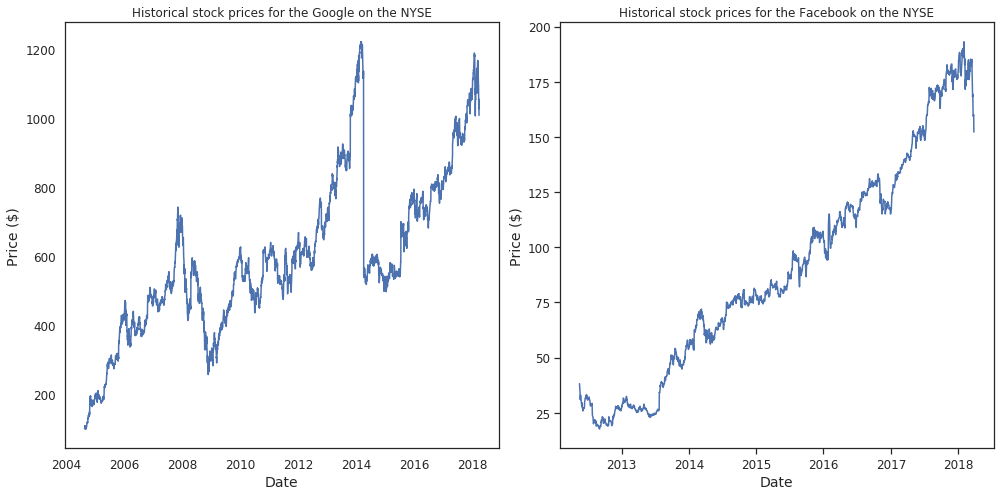

In [18]:
# Defining a figure and its grid specification
fig = plt.figure(figsize = (14,7))
gs = fig.add_gridspec(1, 2)


# First graph of subplot
with sns.axes_style("white"):
    ax = fig.add_subplot(gs[0, 0])
    sns.lineplot(google_data.date, google_data.close)
    plt.title('Historical stock prices for the Google on the NYSE')
    plt.ylabel('Price ($)');
    plt.xlabel('Date');


# Second graph of subplot
with sns.axes_style("ticks"):
    ax = fig.add_subplot(gs[0, 1])
    sns.lineplot(facebook_data.date, facebook_data.close)
    plt.title('Historical stock prices for the Facebook on the NYSE')
    plt.ylabel('Price ($)');
    plt.xlabel('Date');


fig.tight_layout()

### Calculate Market Value of Companies

In [19]:
# Yearly average number of shares outstanding for Google and Facebook

google_shares = pd.DataFrame({'year':['2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015',
                                      '2016', '2017', '2018', '2019'], 
                              'shares':['584', '619', '632', '635', '639', '647', '654', '665', '737', '742', '745', '748',
                                        '751', '750', '745']}).astype(int)

facebook_shares = pd.DataFrame({'year':['2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017',
                                        '2018', '2019'], 
                              'shares':['863', '933', '2732', '1414', '1508', '2166', '2517', '2664', '2853', '2925',
                                        '2956', '2921', '2876']}).astype(int)

In [20]:
# Creating Year column and mergind the dataframes
google_data['year'] = google_data['date'].dt.year
google_data = google_data.merge(google_shares, on='year')
    
facebook_data['year'] = facebook_data['date'].dt.year
facebook_data = facebook_data.merge(facebook_shares, on='year')

In [21]:
# Creating the variable Market Value
def market_value(df):
    # Calculating market value from companies in billions of dollars
    df['market_value'] = (df.shares*df.adj_close)/1e6
    
market_value(google_data)
market_value(facebook_data)

### Visual comparison

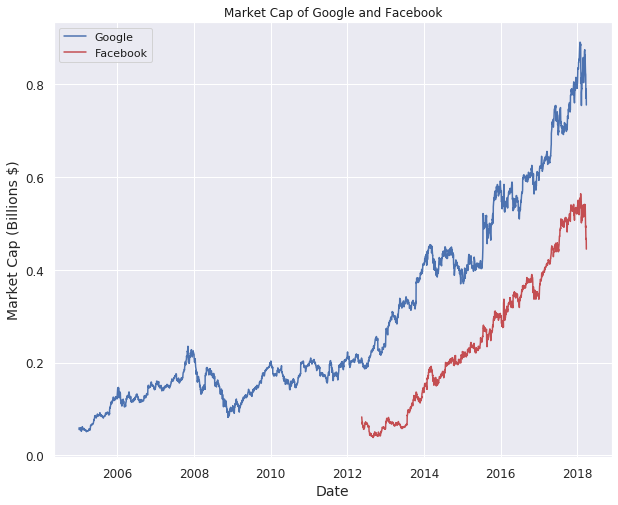

In [22]:
plt.figure(figsize=(10, 8))
plt.plot(google_data['date'], google_data['market_value'], 'b-', label = 'Google')
plt.plot(facebook_data['date'], facebook_data['market_value'], 'r-', label = 'Facebook')
plt.xlabel('Date'); plt.ylabel('Market Cap (Billions $)'); plt.title('Market Cap of Google and Facebook')
plt.legend();

### Prophet model for Google

/home/wbendinelli/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


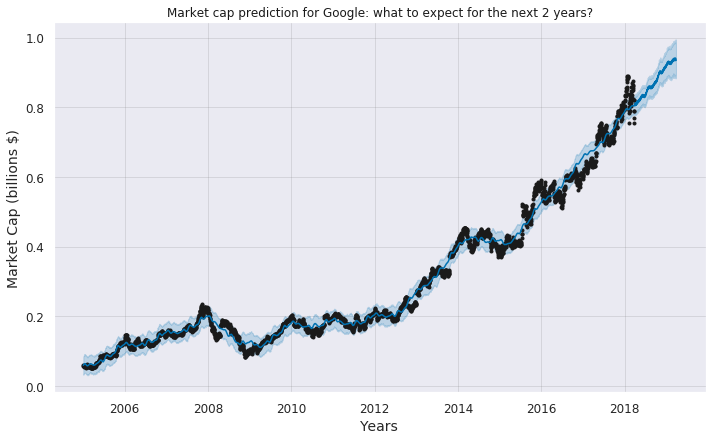

In [33]:
# Prophet requires columns ds (Date) and y (value)
google_prediction = google_data[['date', 'market_value']]
google_prediction.rename(columns={'date': 'ds', 'market_value': 'y'}, inplace=True);

# Make the prophet models and fit on the data
# changepoint_prior_scale can be changed to achieve a better fit
google_prophet = fbprophet.Prophet(changepoint_prior_scale=0.05)
google_prophet.fit(google_prediction);

# Make a future dataframe for 2 years
google_forecast = google_prophet.make_future_dataframe(periods=365, freq='D')

# Make predictions for 2 years
google_forecast = google_prophet.predict(google_forecast)

# Graph predictions
google_prophet.plot(google_forecast, xlabel = 'Years', ylabel = 'Market Cap (billions $)')
plt.title('Market cap prediction for Google: what to expect for the next 2 years?');

### Prophet model for Facebook


/home/wbendinelli/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


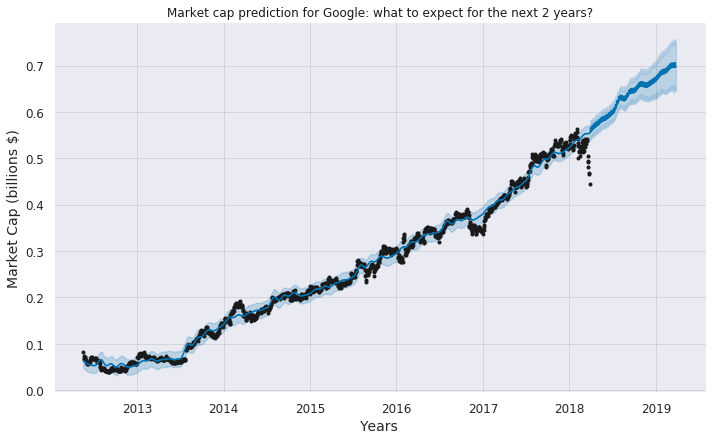

In [24]:
# Prophet requires columns ds (Date) and y (value)
facebook_prediction = facebook_data[['date', 'market_value']]
facebook_prediction.rename(columns={'date': 'ds', 'market_value': 'y'}, inplace=True);

# Make the prophet models and fit on the data
# changepoint_prior_scale can be changed to achieve a better fit
facebook_prophet = fbprophet.Prophet(changepoint_prior_scale=0.05)
facebook_prophet.fit(facebook_prediction);

# Make a future dataframe for 1 years
facebook_forecast = facebook_prophet.make_future_dataframe(periods=365, freq='D')

# Make predictions for 1 years
facebook_forecast = facebook_prophet.predict(facebook_forecast)

# Graph predictions
facebook_prophet.plot(facebook_forecast, xlabel = 'Years', ylabel = 'Market Cap (billions $)')
plt.title('Market cap prediction for Google: what to expect for the next 2 years?');

## Effect of Changepoint Prior Scale

In [34]:
# Try 4 different changepoints
for changepoint in [0.001, 0.05, 0.1]:
    model = fbprophet.Prophet(daily_seasonality=False, changepoint_prior_scale=changepoint)
    model.fit(google_prediction)
    
    future = model.make_future_dataframe(periods=365, freq='D')
    future = model.predict(future)
    
    google_prediction[changepoint] = future['yhat']

/home/wbendinelli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [35]:
google_prediction

,ds,y,0.001,0.05,0.1
0,2005-01-03,0.059375,0.105435,0.058922,0.055113
1,2005-01-04,0.056970,0.105608,0.059466,0.055720
2,2005-01-05,0.056680,0.105984,0.060205,0.056521
3,2005-01-06,0.055227,0.106400,0.060522,0.056870
4,2005-01-07,0.056779,0.106374,0.060826,0.057283
...,...,...,...,...,...
3325,2018-03-21,0.820500,0.756561,0.804986,0.803903
3326,2018-03-22,0.789863,0.756559,0.804777,0.803651
3327,2018-03-23,0.769912,0.756109,0.804572,0.803478
3328,2018-03-26,0.790567,0.755250,0.804646,0.803451


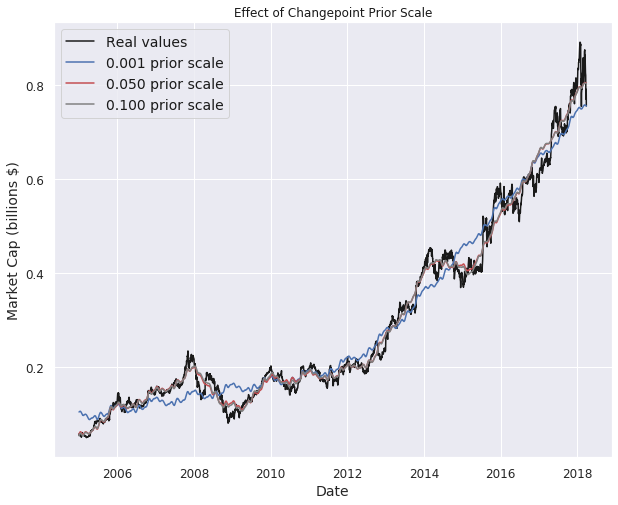

In [36]:
# Create the plot
plt.figure(figsize=(10, 8))

# Actual observations
plt.plot(google_prediction['ds'], google_prediction['y'], 'k', label = 'Real values')
colors = {0.001: 'b', 0.05: 'r', 0.1: 'grey'}

# Plot each of the changepoint predictions
for changepoint in [0.001, 0.05, 0.1]:
    plt.plot(google_prediction['ds'], google_prediction[changepoint], color = colors[changepoint], label = '%.3f prior scale' % changepoint)
    
plt.legend(prop={'size': 14})
plt.xlabel('Date'); plt.ylabel('Market Cap (billions $)'); plt.title('Effect of Changepoint Prior Scale');

### Trends and Patterns

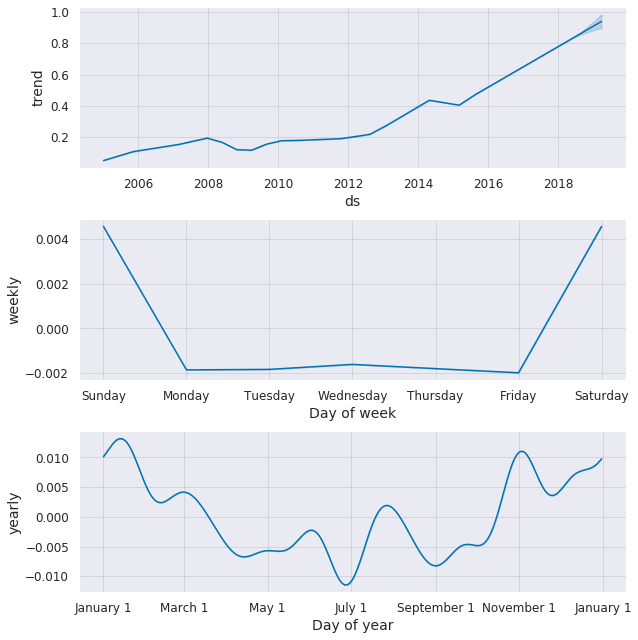

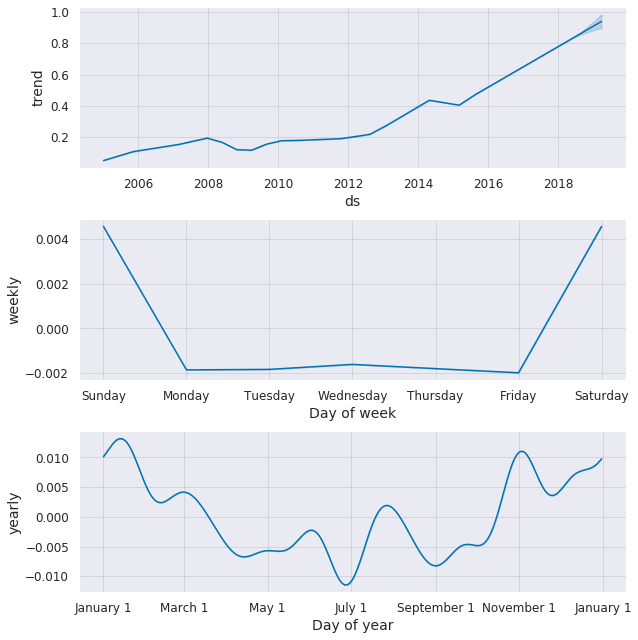

In [37]:
google_prophet.plot_components(google_forecast)

### Do Google searches correlation with changepoints?

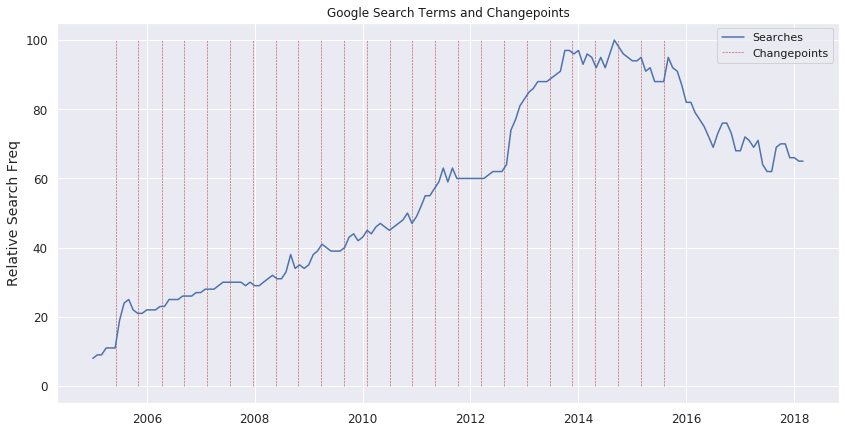

In [51]:
# Load in the data 
google_search = pd.read_csv('/mnt/c/Users/cs316987/Desktop/multiTimeline.csv')

# Convert month to a datetime and select a period
google_search['month'] = pd.to_datetime(google_search['month'])
google_search = google_search[(google_search.month >= '2005-01-01') & (google_search.month <= '2018-03-27')]
google_changepoints = google_prophet.changepoints

# Plot the search frequency

fig = plt.figure(figsize = (14,7))

plt.plot(google_search['month'], google_search['search'], label = 'Searches')

# Plot the changepoints
plt.vlines(google_changepoints, ymin = 0, ymax= 100, colors = 'r', linewidth=0.6, linestyles = 'dashed', label = 'Changepoints')
plt.grid('off'); plt.ylabel('Relative Search Freq'); plt.legend()
plt.title('Google Search Terms and Changepoints');